This notebook loads the data and picks out random subsets if a smaller dataset is desired. Then it trains and tests my implementation of the DeepShadows CNN with DES images, before performing a transfer learning test on HSC images. This code is heavily based on the DeepShadows.ipynb notebook in the repository: https://github.com/dtanoglidis/DeepShadows

In [11]:
# imports
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras import layers as lyr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
matplotlib.rcParams.update({'font.size': 15}) 
%matplotlib inline

## Training

In [10]:
# load the data

np.random.seed(788739854) # set a seed to pick out consistent subsets of the full dataset when re-running

batch_size = 64 # batch size, real DeepShadows uses 64

# load the full datasets
# examples
X_tr = np.float64(np.load('Data/X_train.npy'))[0,:] # training
X_val = np.float64(np.load('Data/X_val.npy'))[0,:] # validation
X_test = np.float64(np.load('Data/X_test.npy'))[0,:] # test
# labels
y_tr = np.int64(np.load('Data/y_train.npy'))[0,:] # training
y_val = np.int64(np.load('Data/y_val.npy'))[0,:] # validation
y_test = np.int64(np.load('Data/y_test.npy'))[0,:] # test

# if we want to use a subset of the data rather than the whole thing, pick out the subset randomly
# [train, validation, test] list with the desired number of batches in each set
num_batches = np.array([468, 77, 77]) # full dataset

# draw random samples of indices for each set of the desired lengths
tr_idx = np.random.choice(np.arange(len(y_tr)), size=num_batches[0]*batch_size, replace=False)
val_idx = np.random.choice(np.arange(len(y_val)), size=num_batches[1]*batch_size, replace=False)
test_idx = np.random.choice(np.arange(len(y_test)), size=num_batches[2]*batch_size, replace=False)

# then pick these out
X_tr = X_tr[tr_idx]
y_tr = y_tr[tr_idx]

X_val = X_val[val_idx]
y_val = y_val[val_idx]

X_test = X_test[test_idx]
y_test = y_test[test_idx]

30000 4990 4990


In [4]:
# Define the DeepShadows CNN
def DeepShadows():
    # architecture
    net = keras.models.Sequential([
        # input layer is the same shape as an image, with the channels last
        lyr.InputLayer((64,64,3)),
        # Each of the first three blocks contains a convolutional layer with relu activation and weight decay
        lyr.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        # followed by batch normalization
        lyr.BatchNormalization(),
        # and max pooling
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        # finally, apply dropout
        lyr.Dropout(rate=0.4),
        # repeat this block twice more, while doubling the number of channels each time
        lyr.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        lyr.BatchNormalization(),
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        lyr.Dropout(rate=0.4),
        # last block, double channels again
        lyr.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.13)),
        lyr.BatchNormalization(),
        lyr.MaxPool2D(pool_size=2, strides=None, padding='valid'),
        lyr.Dropout(rate=0.4),
        # flatten the output so it can be put into the dense layers
        lyr.Flatten(),
        # fully connected layers
        lyr.Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)), # lower the weight decay parameter a bit
        # last layer uses sigmoid activation to output a single probability that the image contains a LSBG
        lyr.Dense(units=1, activation='sigmoid')
    ])
    
    # compile the network for training. 
    # DeepShadows uses Adadelta with a base learning rate of 0.1,
    # cross-entropy loss, 
    # and we want the network to be evaluated by its accuracy
    net.compile(optimizer=optimizers.Adadelta(0.1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return net

In [5]:
# training
n_epochs = 100 # number of epochs

# callback function to save a checkpoint every 10 epochs during training
checkpt = keras.callbacks.ModelCheckpoint(filepath='training_checkpoints/checkpoint', verbose=1, 
                                          save_weights_only=True, save_freq=(10*num_batches[0]))

# create and train the network
net = DeepShadows()
net.fit(x=X_tr, y=y_tr, epochs=n_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val,y_val), 
        callbacks=[checkpt])

Epoch 1/100
468/468 [==============================] - 67s 142ms/step - loss: 57.8259 - accuracy: 0.8187 - val_loss: 6.9975 - val_accuracy: 0.5635
Epoch 2/100
171/468 [=========>....................] - ETA: 40s - loss: 4.2187 - accuracy: 0.8700
Epoch 2: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 68s 144ms/step - loss: 2.5275 - accuracy: 0.8761 - val_loss: 1.0311 - val_accuracy: 0.8823
Epoch 3/100
343/468 [====================>.........] - ETA: 17s - loss: 0.7378 - accuracy: 0.8902
Epoch 3: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 67s 144ms/step - loss: 0.6900 - accuracy: 0.8926 - val_loss: 0.5653 - val_accuracy: 0.8748
Epoch 4/100
468/468 [==============================] - 67s 144ms/step - loss: 0.4687 - accuracy: 0.8998 - val_loss: 0.4479 - val_accuracy: 0.8898
Epoch 5/100
 47/468 [==>...........................] - ETA: 57s - loss: 0.4128 - accuracy: 0.9066
Epoch 5: saving model to traini

468/468 [==============================] - 67s 142ms/step - loss: 0.2673 - accuracy: 0.9121 - val_loss: 0.2463 - val_accuracy: 0.9205
Epoch 34/100
468/468 [==============================] - 65s 140ms/step - loss: 0.2679 - accuracy: 0.9138 - val_loss: 0.2529 - val_accuracy: 0.9217
Epoch 35/100
 87/468 [====>.........................] - ETA: 51s - loss: 0.2663 - accuracy: 0.9168
Epoch 35: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 66s 141ms/step - loss: 0.2679 - accuracy: 0.9142 - val_loss: 0.2462 - val_accuracy: 0.9194
Epoch 36/100
259/468 [===============>..............] - ETA: 28s - loss: 0.2673 - accuracy: 0.9124
Epoch 36: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 66s 141ms/step - loss: 0.2673 - accuracy: 0.9129 - val_loss: 0.2715 - val_accuracy: 0.9138
Epoch 37/100
431/468 [==========================>...] - ETA: 5s - loss: 0.2688 - accuracy: 0.9134
Epoch 37: saving model to training_chec

299/468 [==================>...........] - ETA: 22s - loss: 0.2570 - accuracy: 0.9138
Epoch 66: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 201s 430ms/step - loss: 0.2576 - accuracy: 0.9137 - val_loss: 0.2408 - val_accuracy: 0.9209
Epoch 67/100
468/468 [==============================] - 68s 146ms/step - loss: 0.2572 - accuracy: 0.9163 - val_loss: 0.2348 - val_accuracy: 0.9225
Epoch 68/100
  3/468 [..............................] - ETA: 1:06 - loss: 0.2517 - accuracy: 0.9167
Epoch 68: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 69s 147ms/step - loss: 0.2575 - accuracy: 0.9165 - val_loss: 0.2329 - val_accuracy: 0.9239
Epoch 69/100
175/468 [==========>...................] - ETA: 41s - loss: 0.2571 - accuracy: 0.9134
Epoch 69: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 68s 146ms/step - loss: 0.2574 - accuracy: 0.9139 - val_loss: 0.2303 - val_accuracy

468/468 [==============================] - 67s 142ms/step - loss: 0.2518 - accuracy: 0.9162 - val_loss: 0.2378 - val_accuracy: 0.9207
Epoch 99/100
215/468 [============>.................] - ETA: 34s - loss: 0.2489 - accuracy: 0.9172
Epoch 99: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 67s 144ms/step - loss: 0.2527 - accuracy: 0.9160 - val_loss: 0.2598 - val_accuracy: 0.9089
Epoch 100/100
387/468 [=======================>......] - ETA: 11s - loss: 0.2520 - accuracy: 0.9181
Epoch 100: saving model to training_checkpoints/checkpoint
468/468 [==============================] - 67s 144ms/step - loss: 0.2528 - accuracy: 0.9170 - val_loss: 0.2444 - val_accuracy: 0.9146


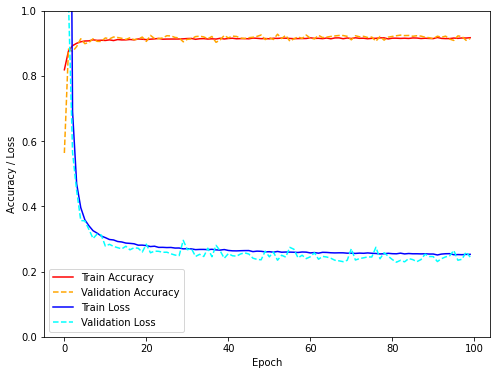

In [6]:
# plot the results
t = np.arange(n_epochs) # array for epoch number

# get performance metrics
performance_data = net.history.history

tr_acc = performance_data['accuracy']
val_acc = performance_data['val_accuracy']
tr_loss = performance_data['loss']
val_loss = performance_data['val_loss']

# and plot everything up
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t, tr_acc, c='r', label='Train Accuracy')
ax.plot(t, val_acc, c='orange', linestyle='dashed', label='Validation Accuracy')
ax.plot(t, tr_loss, c='b', label='Train Loss')
ax.plot(t, val_loss, c='cyan', linestyle='dashed', label='Validation Loss')

ax.set(xlabel='Epoch', ylabel='Accuracy / Loss', ylim=(0,1))

ax.legend()
plt.show()

In [7]:
# save the trained network
net.save('Trained_networks/DeepShadows_tf')

INFO:tensorflow:Assets written to: Trained_networks/DeepShadows_tf/assets


## Testing

In [8]:
# evaluate the network's accuracy on the test set
test_loss, test_acc = net.evaluate(X_test, y_test, verbose=2)
print('Test Accuracy: {}'.format(test_acc))

154/154 - 4s - loss: 0.2582 - accuracy: 0.9095 - 4s/epoch - 24ms/step
Test Accuracy: 0.9094967246055603


In [26]:
# compute the confusion matrix for the test set
thres = 0.5 # threshold probability for a LSBG prediction

y_prob = net.predict(X_test) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx = np.argwhere(y_prob > thres)

# now make an array of the predicted classes based on the threshold
y_pred = np.zeros_like(y_prob, dtype=int)
y_pred[LSBG_idx] = 1

# compute the confusion matrix
conf_mat_DES = confusion_matrix(y_test, y_pred) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_DES[1,1]))
print("True negatives:  {:4}".format(conf_mat_DES[0,0]))
print("False positives: {:4}".format(conf_mat_DES[0,1]))
print("False negatives: {:4}".format(conf_mat_DES[1,0]))

True positives:  2389
True negatives:  2092
False positives:  374
False negatives:   73


## Transfer Learning

In [32]:
# load the HSC data

batch_size_tl = 32 # batch size, real DeepShadows uses 32 for retraining

# load the full HSC datasets since there's not that many
# examples
X_tr_hsc = np.float64(np.load('Data/X_HSC_train.npy'))[0,:] # training
X_test_hsc = np.float64(np.load('Data/X_HSC_test.npy'))[0,:] # test
# labels
y_tr_hsc = np.int64(np.load('Data/y_HSC_train.npy'))[0,:] # training
y_test_hsc = np.int64(np.load('Data/y_HSC_test.npy'))[0,:] # test

# load the saved trained network
net = keras.models.load_model('Trained_networks/DeepShadows_tf')

In [33]:
# evaluate the un-retrained network's accuracy on the test set
test_loss_hsc, test_acc_hsc = net.evaluate(X_test_hsc, y_test_hsc, verbose=2)
print('Test Accuracy: {}'.format(test_acc_hsc))

30/30 - 1s - loss: 0.4975 - accuracy: 0.8146 - 865ms/epoch - 29ms/step
Test Accuracy: 0.8145833611488342


In [34]:
# compute the confusion matrix for the test set
y_prob_hsc = net.predict(X_test_hsc) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx_hsc = np.argwhere(y_prob_hsc > thres)

# now make an array of the predicted classes based on the threshold
y_pred_hsc = np.zeros_like(y_prob_hsc, dtype=int)
y_pred_hsc[LSBG_idx_hsc] = 1

# compute the confusion matrix
conf_mat_HSC = confusion_matrix(y_test_hsc, y_pred_hsc) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_HSC[1,1]))
print("True negatives:  {:4}".format(conf_mat_HSC[0,0]))
print("False positives: {:4}".format(conf_mat_HSC[0,1]))
print("False negatives: {:4}".format(conf_mat_HSC[1,0]))

True positives:   396
True negatives:   386
False positives:   94
False negatives:   84


In [40]:
# now, recompile and train the model with a much smaller learning rate (transfer learning)
n_epochs_tl = 30 # number of transfer learning epochs

# recompile
net.compile(optimizer=optimizers.Adadelta(0.005), loss='binary_crossentropy', metrics=['accuracy'])

# and train. We won't save checkpoints this time since this step goes quite quickly
net.fit(x=X_tr_hsc, y=y_tr_hsc, epochs=n_epochs_tl, batch_size=batch_size_tl, shuffle=True)

Epoch 1/30
10/10 [==============================] - 2s 107ms/step - loss: 0.3374 - accuracy: 0.8687
Epoch 2/30
10/10 [==============================] - 1s 90ms/step - loss: 0.3243 - accuracy: 0.8719
Epoch 3/30
10/10 [==============================] - 1s 94ms/step - loss: 0.3400 - accuracy: 0.8750
Epoch 4/30
10/10 [==============================] - 1s 89ms/step - loss: 0.3288 - accuracy: 0.8687
Epoch 5/30
10/10 [==============================] - 1s 89ms/step - loss: 0.3283 - accuracy: 0.8781
Epoch 6/30
10/10 [==============================] - 1s 86ms/step - loss: 0.3088 - accuracy: 0.8844
Epoch 7/30
10/10 [==============================] - 1s 86ms/step - loss: 0.3070 - accuracy: 0.9062
Epoch 8/30
10/10 [==============================] - 1s 90ms/step - loss: 0.3181 - accuracy: 0.8844
Epoch 9/30
10/10 [==============================] - 1s 88ms/step - loss: 0.3294 - accuracy: 0.8719
Epoch 10/30
10/10 [==============================] - 1s 92ms/step - loss: 0.3147 - accuracy: 0.8781
Epoch 11

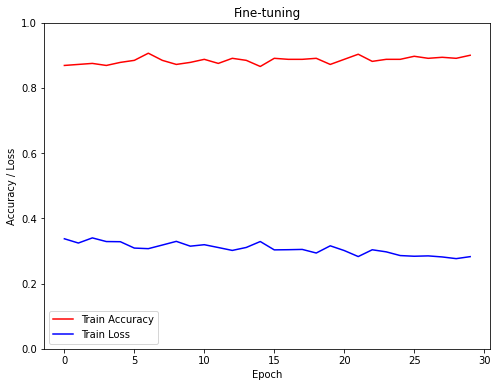

In [42]:
# plot the results
t = np.arange(n_epochs_tl) # array for epoch number

# get performance metrics
performance_data = net.history.history

tr_acc = performance_data['accuracy']
tr_loss = performance_data['loss']

# and plot everything up
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t, tr_acc, c='r', label='Train Accuracy')
ax.plot(t, tr_loss, c='b', label='Train Loss')

ax.set(title='Fine-tuning', xlabel='Epoch', ylabel='Accuracy / Loss', ylim=(0,1))

ax.legend()
plt.show()

In [43]:
# save the retuned network
net.save('Trained_networks/DeepShadows_tf_HSC')

INFO:tensorflow:Assets written to: Trained_networks/DeepShadows_tf_HSC/assets


In [44]:
# evaluate the retrained network's accuracy on the test set
test_loss_HSC_tuned, test_acc_HSC_tuned = net.evaluate(X_test_hsc, y_test_hsc, verbose=2)
print('Test Accuracy: {}'.format(test_acc_HSC_tuned))

30/30 - 1s - loss: 0.3941 - accuracy: 0.8552 - 830ms/epoch - 28ms/step
Test Accuracy: 0.8552083373069763


In [47]:
# compute the confusion matrix for the test set
y_prob_hsc_tuned = net.predict(X_test_hsc) # get predicted probabilities
# and figure out which indices are over the threshold probability
LSBG_idx_hsc_tuned = np.argwhere(y_prob_hsc_tuned > thres)

# now make an array of the predicted classes based on the threshold
y_pred_hsc_tuned = np.zeros_like(y_prob_hsc_tuned, dtype=int)
y_pred_hsc_tuned[LSBG_idx_hsc_tuned] = 1

# compute the confusion matrix
conf_mat_HSC_tuned = confusion_matrix(y_test_hsc, y_pred_hsc_tuned) # rows are true, columns are predicted
# and print out the entries nicely
print("True positives:  {:4}".format(conf_mat_HSC_tuned[1,1]))
print("True negatives:  {:4}".format(conf_mat_HSC_tuned[0,0]))
print("False positives: {:4}".format(conf_mat_HSC_tuned[0,1]))
print("False negatives: {:4}".format(conf_mat_HSC_tuned[1,0]))

True positives:   419
True negatives:   402
False positives:   78
False negatives:   61
